In [ ]:
!pip install streamlit
!pip install pyngrok

In [ ]:
!pip install xgboost
!pip install tensorflow
!pip install scikit-learn
!pip install pandas
!pip install faker

In [ ]:
from google.colab import files
uploaded = files.upload()

# After uploading, load it into pandas
import pandas as pd
df = pd.read_csv('supply_chain_300_records.csv')


Saving supply_chain_300_records.csv to supply_chain_300_records (2).csv


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Load the dataset
df = pd.read_csv('supply_chain_300_records.csv')

# Feature engineering: convert 'Sales Date' to a numerical format (year, month)
df['Sales Date'] = pd.to_datetime(df['Sales Date'])
df['Year'] = df['Sales Date'].dt.year
df['Month'] = df['Sales Date'].dt.month

# Drop columns not useful for prediction
df = df.drop(['Product Name', 'Sales Date', 'Customer ID', 'Supplier ID', 'Product ID'], axis=1)

# Convert categorical data to numerical using one-hot encoding
df = pd.get_dummies(df, columns=['Category', 'Warehouse Location', 'Promotional Campaign', 'Seasonal Indicator'])

# Features (X) and Target (y)
X = df.drop('Quantity Sold', axis=1)
y = df['Quantity Sold']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"XGBoost RMSE: {rmse}")

# Output first 10 predictions
print("Predicted vs Actual (First 10):")
print(pd.DataFrame({'Predicted': y_pred[:10], 'Actual': y_test[:10].values}))


XGBoost RMSE: 14.067141133903867
Predicted vs Actual (First 10):
   Predicted  Actual
0  24.374565      28
1  27.146744      35
2  24.481499      13
3  25.227280      36
4  25.925035       5
5  25.299034      37
6  25.453308      48
7  24.950682      45
8  24.478575       1
9  24.681961       2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the dataset
df = pd.read_csv('supply_chain_300_records.csv')

# Feature engineering: convert 'Sales Date' to a numerical format (year, month)
df['Sales Date'] = pd.to_datetime(df['Sales Date'])
df['Year'] = df['Sales Date'].dt.year
df['Month'] = df['Sales Date'].dt.month

# Select the relevant columns for time series (e.g., 'Quantity Sold' as target, 'Current Stock Level' as a feature)
df = df[['Sales Date', 'Current Stock Level', 'Quantity Sold']].sort_values('Sales Date')

# Normalize the features for LSTM input
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['Current Stock Level', 'Quantity Sold']])

# Prepare the data for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])  # Using 'Current Stock Level' as the input feature
        y.append(data[i, 1])  # Predict 'Quantity Sold'
    return np.array(X), np.array(y)

# Create sequences
n_steps = 10  # Lookback window of 10 days
X, y = create_sequences(df_scaled, n_steps)

# Reshape X to be (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predicted values
y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], 1)), y_pred), axis=1))[:, 1]
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], 1)), y_test.reshape(-1, 1)), axis=1))[:, 1]

# Evaluate the model using RMSE
rmse_lstm = np.sqrt(np.mean((y_pred_inv - y_test_inv) ** 2))
print(f"LSTM RMSE: {rmse_lstm}")

# Output first 10 predictions
print("Predicted vs Actual (First 10):")
print(pd.DataFrame({'Predicted': y_pred_inv[:10], 'Actual': y_test_inv[:10]}))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.3306
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2626
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2138
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1507 
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0925
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0903 
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0865 
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0845 
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0872 
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0850
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0864 
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0867 
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0881 
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0840
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0929
Epoch 16/20
8/8 ━━━━━━━━━━━━━━━━━━━━

Index(['Product ID', 'Product Name', 'Category', 'Current Stock Level',
       'Reorder Point', 'Lead Time (Days)', 'Supplier ID', 'Sales Date',
       'Quantity Sold', 'Sales Price', 'Customer ID', 'Warehouse Location',
       'Inventory Turnover Rate', 'Promotional Campaign',
       'Seasonal Indicator'],
      dtype='object')


<ipython-input-80-552a6557e1f2>:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='Year', y='Quantity Sold', ci=None)


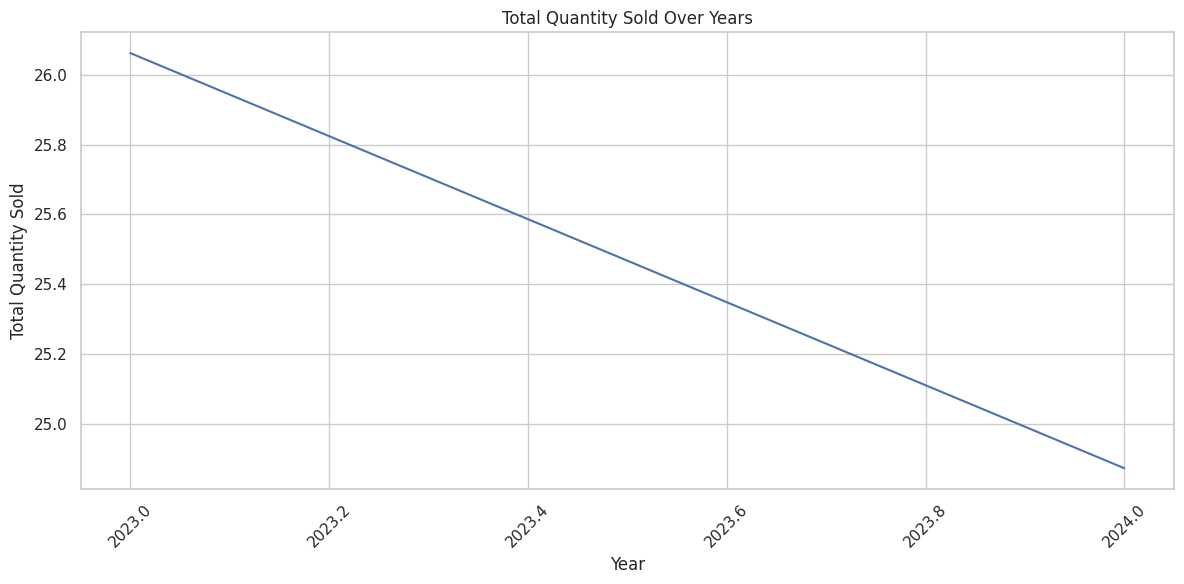

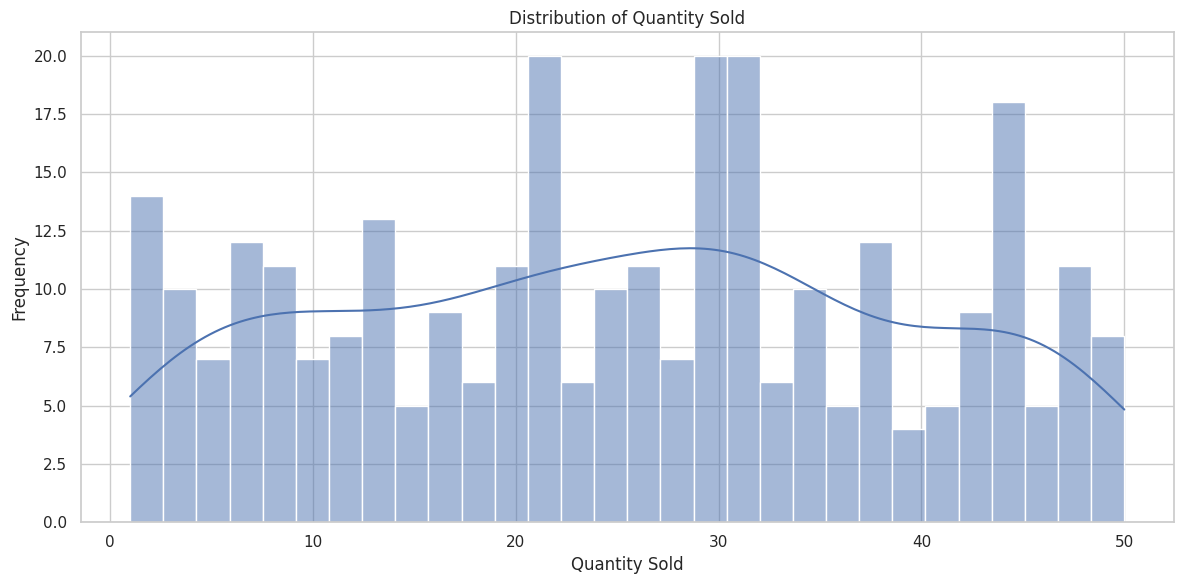

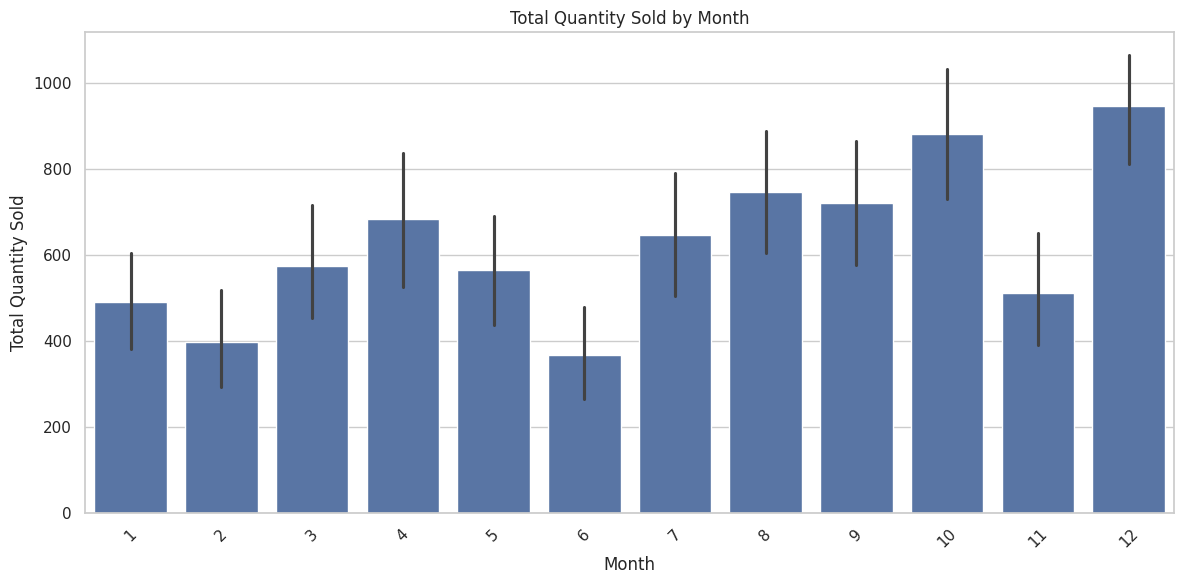

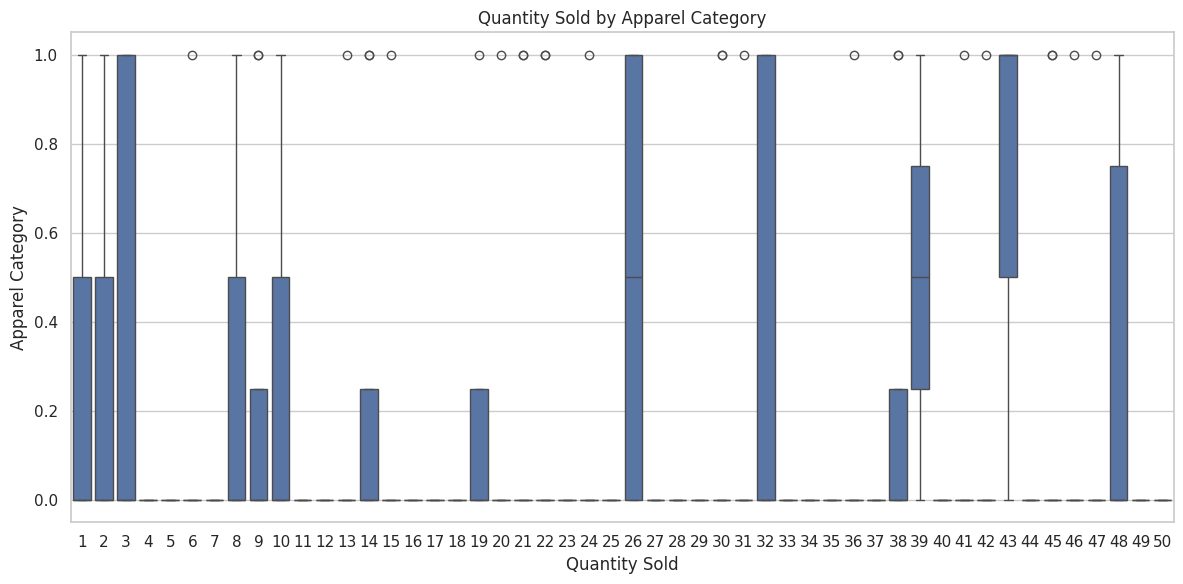

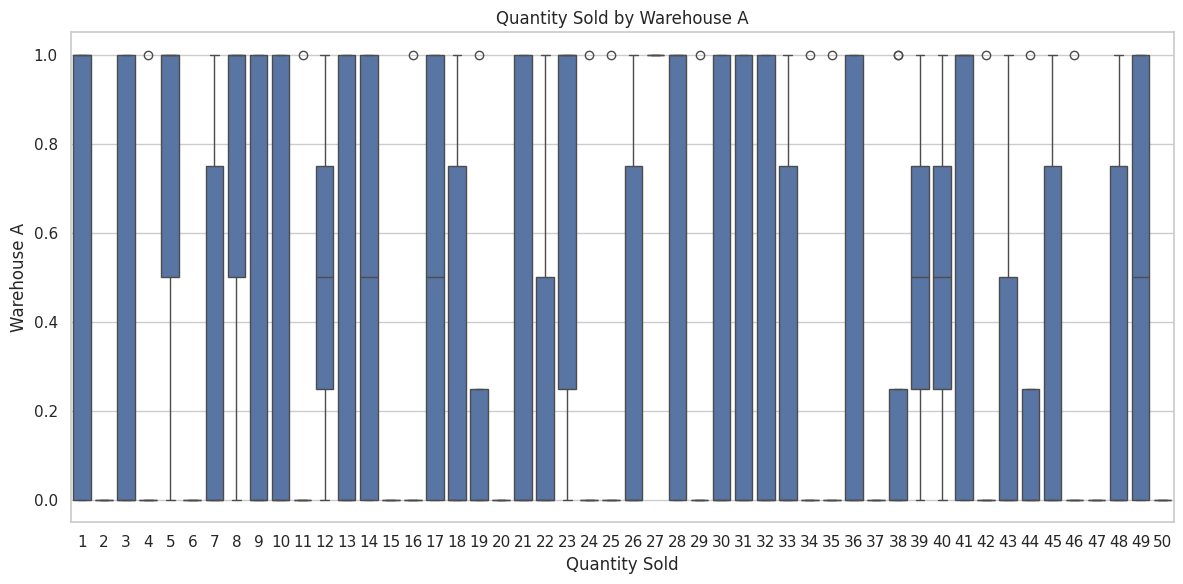

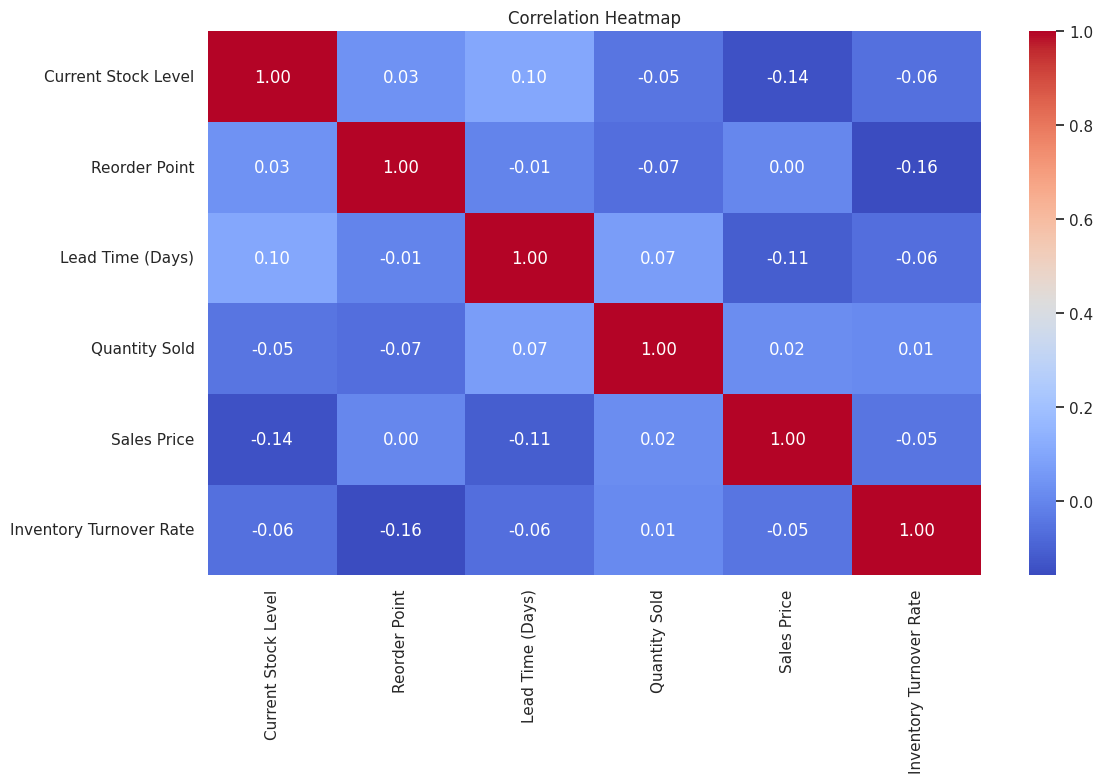

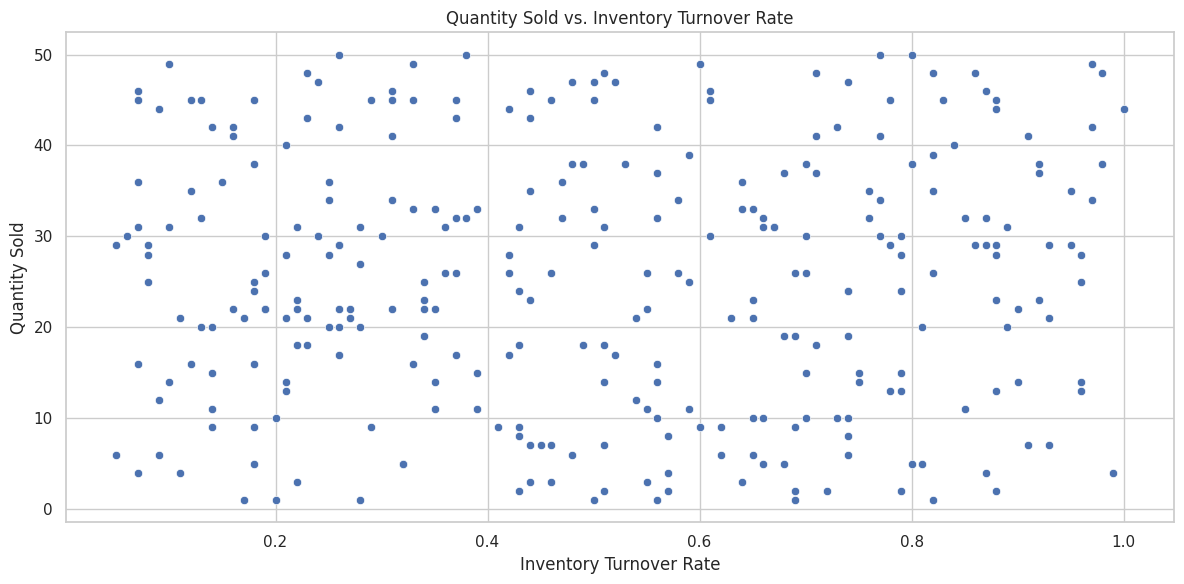

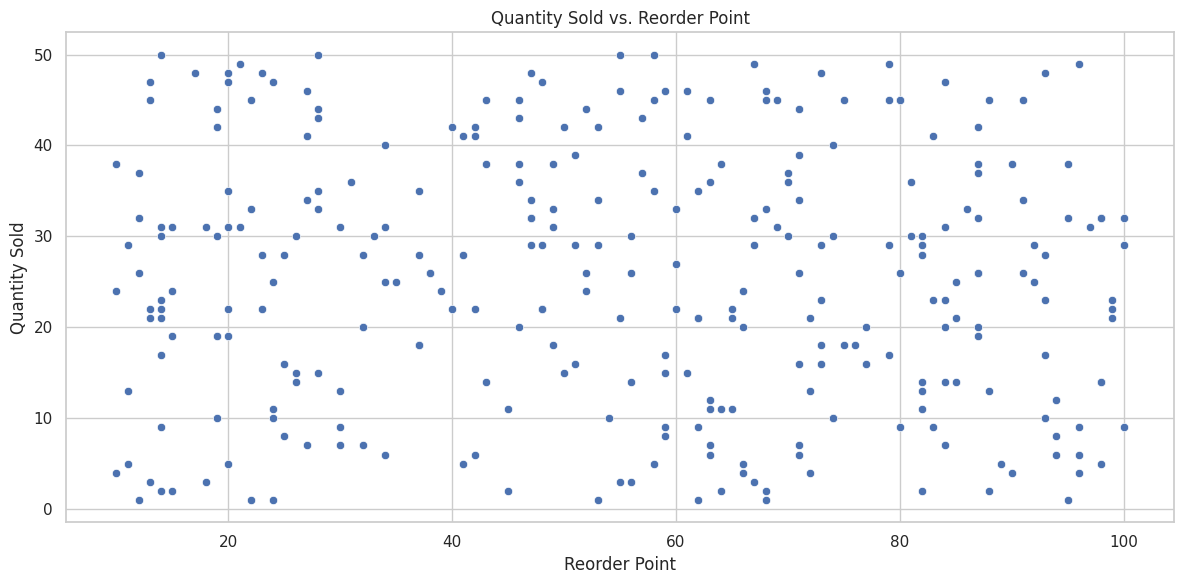

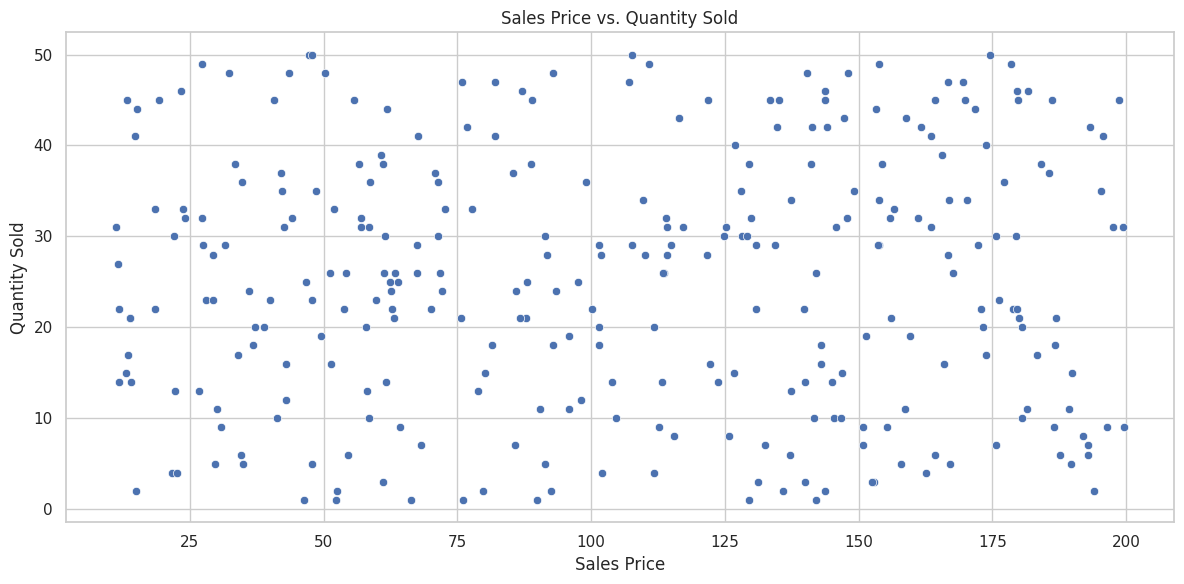

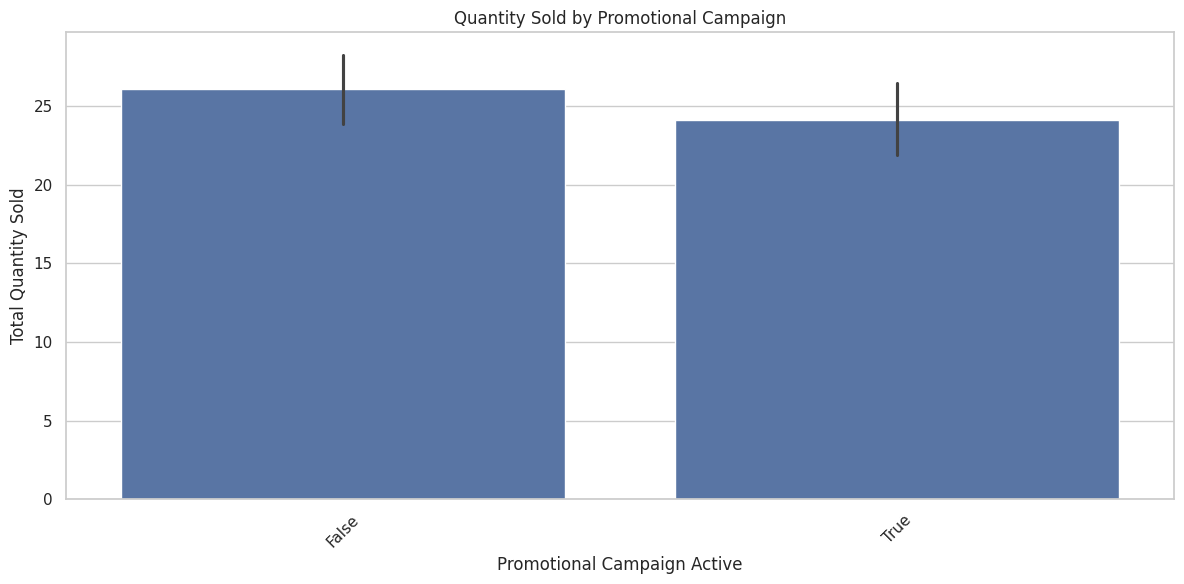

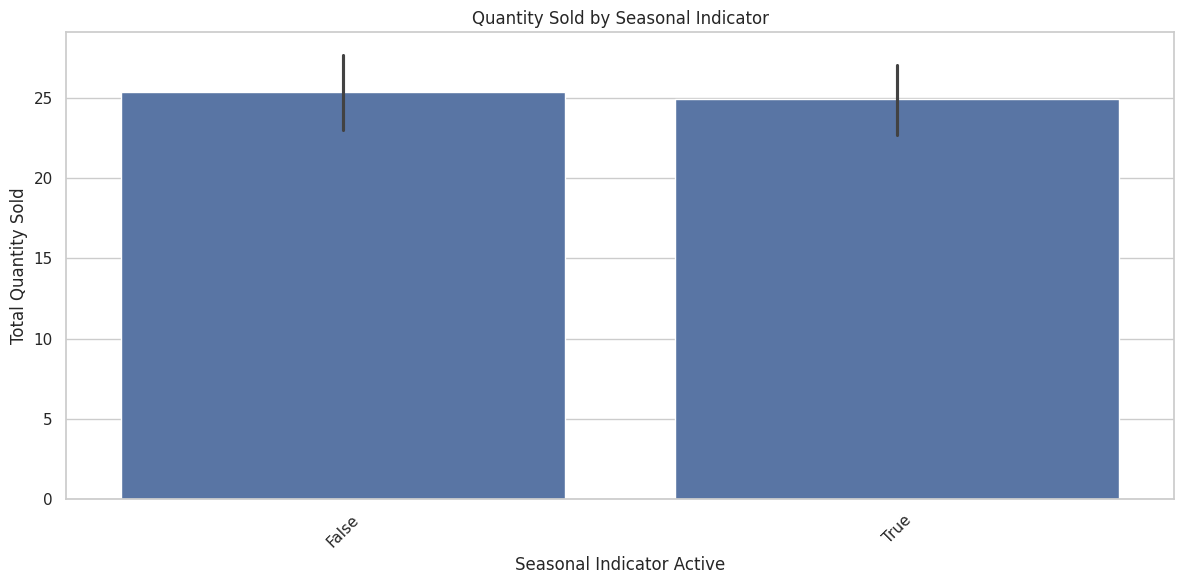

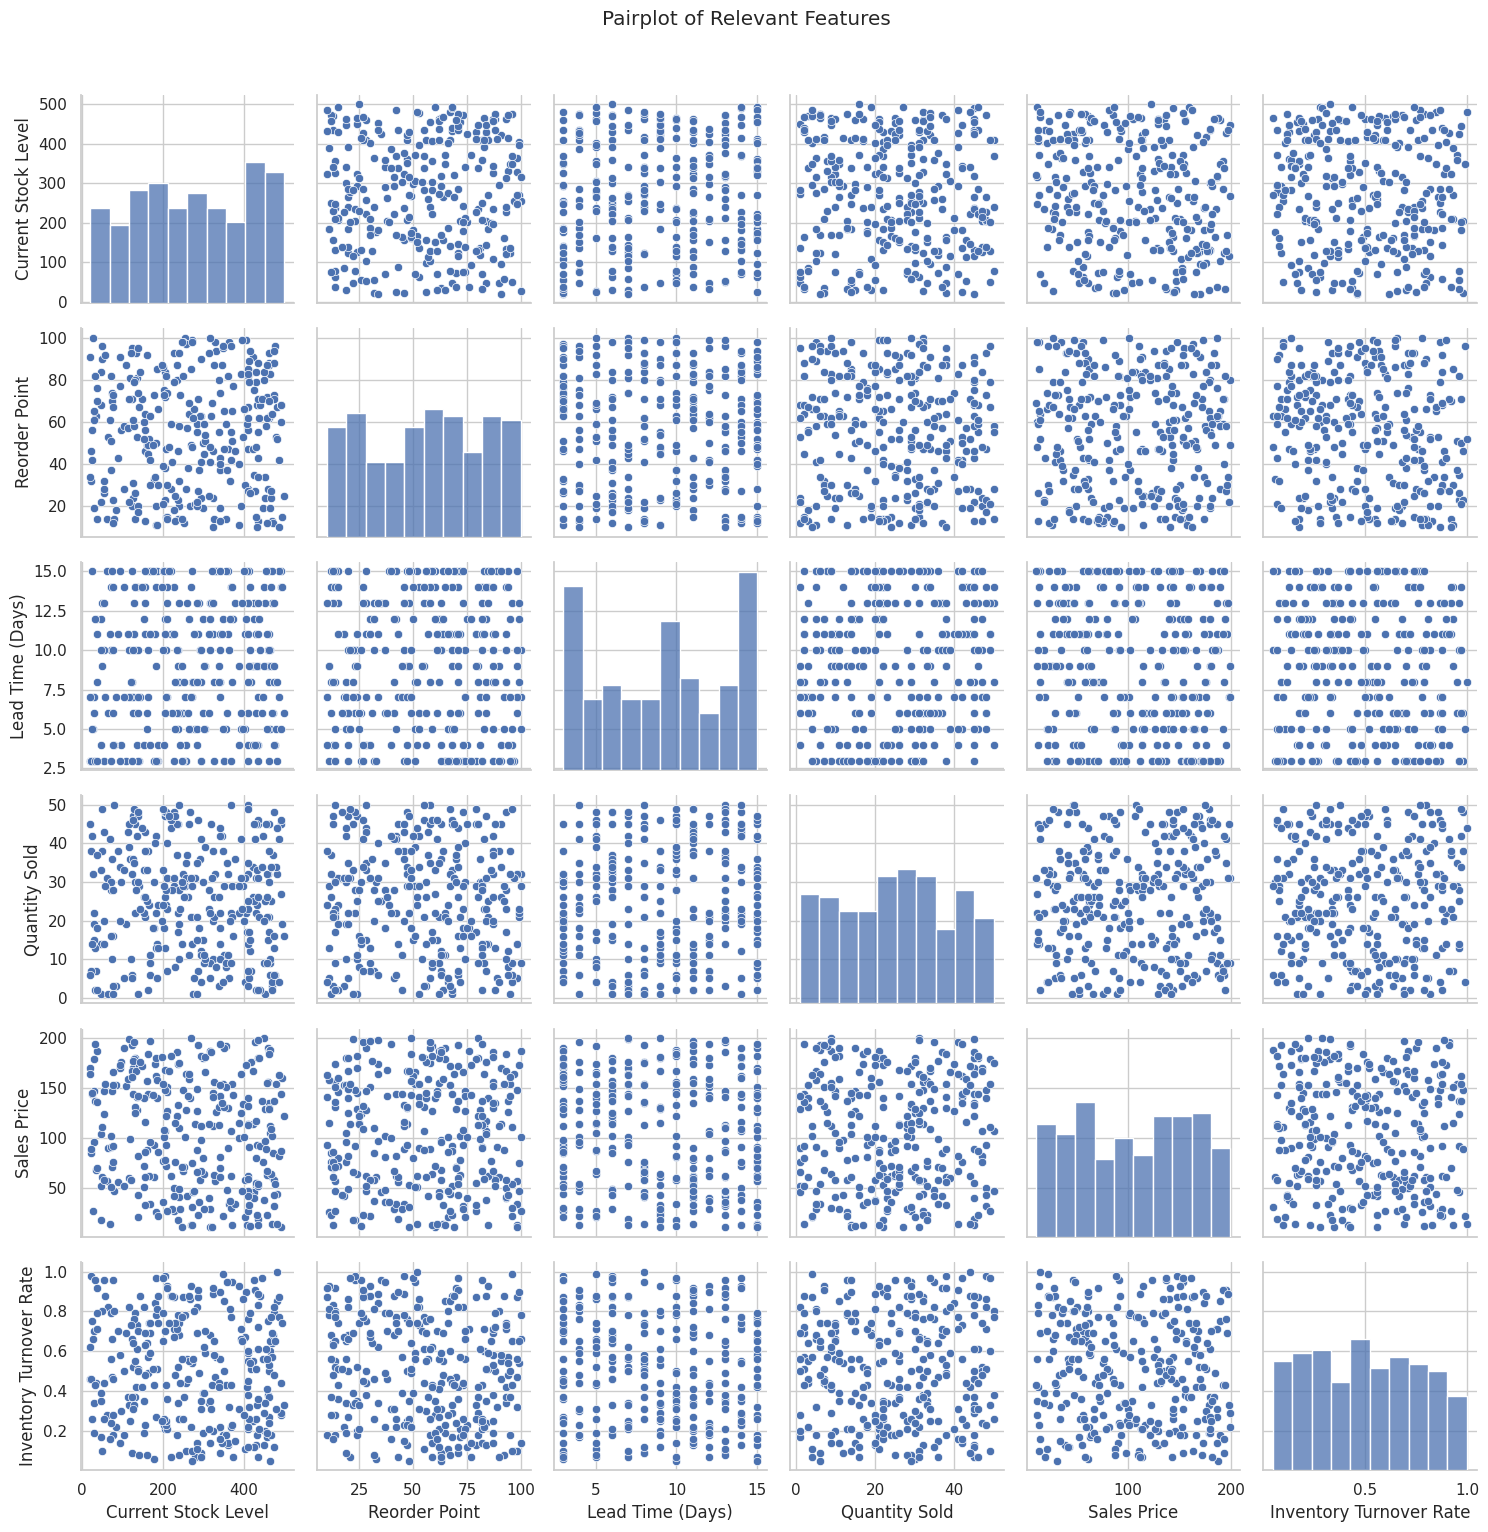

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('supply_chain_300_records.csv')
print(df.columns)
# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Convert categorical data to numerical using one-hot encoding
df = pd.get_dummies(df, columns=['Category', 'Warehouse Location', 'Promotional Campaign', 'Seasonal Indicator'])

# Ensure 'Year' is present, or create it if not
if 'Year' not in df.columns:
    df['Sales Date'] = pd.to_datetime(df['Sales Date'])
    df['Year'] = df['Sales Date'].dt.year
    df['Month'] = df['Sales Date'].dt.month
    df['Day'] = df['Sales Date'].dt.day


# 1. Total Quantity Sold Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='Quantity Sold', ci=None)
plt.title('Total Quantity Sold Over Years')
plt.xlabel('Year')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Quantity Sold Distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['Quantity Sold'], bins=30, kde=True)
plt.title('Distribution of Quantity Sold')
plt.xlabel('Quantity Sold')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 3. Quantity Sold by Month
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Month', y='Quantity Sold', estimator=sum)
plt.title('Total Quantity Sold by Month')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Boxplot of Quantity Sold by Apparel Category
# Check if Category_Apparel exists
if 'Category_Apparel' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='Quantity Sold', y='Category_Apparel')
    plt.title('Quantity Sold by Apparel Category')
    plt.xlabel('Quantity Sold')
    plt.ylabel('Apparel Category')
    plt.tight_layout()
    plt.show()
else:
    print("Column 'Category_Apparel' does not exist.")

# 5. Boxplot of Quantity Sold by Warehouse Location
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Quantity Sold', y='Warehouse Location_Warehouse A')
plt.title('Quantity Sold by Warehouse A')
plt.xlabel('Quantity Sold')
plt.ylabel('Warehouse A')
plt.tight_layout()
plt.show()

# 6. Heatmap of Correlation
plt.figure(figsize=(12, 8))

# Select only numeric columns for correlation
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation = df[numeric_cols].corr()

sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# 7. Quantity Sold by Inventory Turnover Rate
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Inventory Turnover Rate', y='Quantity Sold')
plt.title('Quantity Sold vs. Inventory Turnover Rate')
plt.xlabel('Inventory Turnover Rate')
plt.ylabel('Quantity Sold')
plt.tight_layout()
plt.show()

# 8. Quantity Sold by Reorder Point
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Reorder Point', y='Quantity Sold')
plt.title('Quantity Sold vs. Reorder Point')
plt.xlabel('Reorder Point')
plt.ylabel('Quantity Sold')
plt.tight_layout()
plt.show()

# 9. Sales Price vs. Quantity Sold
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Sales Price', y='Quantity Sold')
plt.title('Sales Price vs. Quantity Sold')
plt.xlabel('Sales Price')
plt.ylabel('Quantity Sold')
plt.tight_layout()
plt.show()

# 10. Quantity Sold by Promotional Campaign
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Promotional Campaign_Yes', y='Quantity Sold')
plt.title('Quantity Sold by Promotional Campaign')
plt.xlabel('Promotional Campaign Active')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 11. Quantity Sold by Seasonal Indicator
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Seasonal Indicator_Yes', y='Quantity Sold')
plt.title('Quantity Sold by Seasonal Indicator')
plt.xlabel('Seasonal Indicator Active')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 12. Pairplot of Relevant Features
features_to_plot = ['Current Stock Level', 'Reorder Point', 'Lead Time (Days)', 'Quantity Sold', 'Sales Price', 'Inventory Turnover Rate']
sns.pairplot(df[features_to_plot])
plt.suptitle('Pairplot of Relevant Features', y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
%%writefile app.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import numpy as np

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Load the dataset
df = pd.read_csv('supply_chain_300_records.csv')

# Streamlit app title
st.title('Supply Chain Data Analysis')

# Show the dataset
st.write("Dataset Overview:")
st.dataframe(df.head())

# Convert categorical data to numerical using one-hot encoding
df = pd.get_dummies(df, columns=['Category', 'Warehouse Location', 'Promotional Campaign', 'Seasonal Indicator'])

# Ensure 'Year' is present, or create it if not
if 'Year' not in df.columns:
    df['Sales Date'] = pd.to_datetime(df['Sales Date'])
    df['Year'] = df['Sales Date'].dt.year
    df['Month'] = df['Sales Date'].dt.month
    df['Day'] = df['Sales Date'].dt.day

# Function to display plots
def plot_total_quantity_sold_over_time():
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='Year', y='Quantity Sold', ci=None)
    plt.title('Total Quantity Sold Over Years')
    plt.xlabel('Year')
    plt.ylabel('Total Quantity Sold')
    plt.xticks(rotation=45)
    st.pyplot(plt)

def plot_quantity_sold_distribution():
    plt.figure(figsize=(12, 6))
    sns.histplot(df['Quantity Sold'], bins=30, kde=True)
    plt.title('Distribution of Quantity Sold')
    plt.xlabel('Quantity Sold')
    plt.ylabel('Frequency')
    st.pyplot(plt)

def plot_quantity_sold_by_month():
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Month', y='Quantity Sold', estimator=sum)
    plt.title('Total Quantity Sold by Month')
    plt.xlabel('Month')
    plt.ylabel('Total Quantity Sold')
    plt.xticks(rotation=45)
    st.pyplot(plt)

def plot_boxplot_by_apparel_category():
    if 'Category_Apparel' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x='Quantity Sold', y='Category_Apparel')
        plt.title('Quantity Sold by Apparel Category')
        plt.xlabel('Quantity Sold')
        plt.ylabel('Apparel Category')
        st.pyplot(plt)
    else:
        st.warning("Column 'Category_Apparel' does not exist.")

def plot_boxplot_by_warehouse_location():
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='Quantity Sold', y='Warehouse Location_Warehouse A')
    plt.title('Quantity Sold by Warehouse A')
    plt.xlabel('Quantity Sold')
    plt.ylabel('Warehouse A')
    st.pyplot(plt)

def plot_correlation_heatmap():
    plt.figure(figsize=(12, 8))
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    correlation = df[numeric_cols].corr()
    sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap')
    st.pyplot(plt)

def plot_quantity_sold_vs_inventory_turnover():
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x='Inventory Turnover Rate', y='Quantity Sold')
    plt.title('Quantity Sold vs. Inventory Turnover Rate')
    plt.xlabel('Inventory Turnover Rate')
    plt.ylabel('Quantity Sold')
    st.pyplot(plt)

def plot_quantity_sold_vs_reorder_point():
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x='Reorder Point', y='Quantity Sold')
    plt.title('Quantity Sold vs. Reorder Point')
    plt.xlabel('Reorder Point')
    plt.ylabel('Quantity Sold')
    st.pyplot(plt)

def plot_sales_price_vs_quantity_sold():
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x='Sales Price', y='Quantity Sold')
    plt.title('Sales Price vs. Quantity Sold')
    plt.xlabel('Sales Price')
    plt.ylabel('Quantity Sold')
    st.pyplot(plt)

def plot_quantity_sold_by_promotional_campaign():
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Promotional Campaign_Yes', y='Quantity Sold')
    plt.title('Quantity Sold by Promotional Campaign')
    plt.xlabel('Promotional Campaign Active')
    plt.ylabel('Total Quantity Sold')
    plt.xticks(rotation=45)
    st.pyplot(plt)

def plot_quantity_sold_by_seasonal_indicator():
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Seasonal Indicator_Yes', y='Quantity Sold')
    plt.title('Quantity Sold by Seasonal Indicator')
    plt.xlabel('Seasonal Indicator Active')
    plt.ylabel('Total Quantity Sold')
    plt.xticks(rotation=45)
    st.pyplot(plt)

# Function to plot predicted vs actual quantity sold
def plot_predicted_vs_actual(y_test, y_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_test)), y_test, label='Actual Quantity Sold', marker='o')
    plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted Quantity Sold', marker='x')
    plt.title('Predicted vs Actual Quantity Sold')
    plt.xlabel('Index')
    plt.ylabel('Quantity Sold')
    plt.legend()
    st.pyplot(plt)

# Function to plot feature importance from XGBoost
def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
    plt.title('Top 10 Feature Importance from XGBoost')
    st.pyplot(plt)

# Function to plot LSTM predictions over time
def plot_lstm_predictions(y_test_inv, y_pred_inv):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inv, label='Actual Quantity Sold', marker='o')
    plt.plot(y_pred_inv, label='Predicted Quantity Sold', marker='x')
    plt.title('LSTM Predicted vs Actual Quantity Sold')
    plt.xlabel('Time Step')
    plt.ylabel('Quantity Sold')
    plt.legend()
    st.pyplot(plt)


# Display Plots
st.header("Visualizations")
plot_total_quantity_sold_over_time()
plot_quantity_sold_distribution()
plot_quantity_sold_by_month()
plot_boxplot_by_apparel_category()
plot_boxplot_by_warehouse_location()
plot_correlation_heatmap()
plot_quantity_sold_vs_inventory_turnover()
plot_quantity_sold_vs_reorder_point()
plot_sales_price_vs_quantity_sold()
plot_quantity_sold_by_promotional_campaign()
plot_quantity_sold_by_seasonal_indicator()

# Conclusion Section
st.header("Conclusions")
st.write("""
- The total quantity sold has shown significant trends over the years.
- Certain months exhibit higher sales volumes, indicating seasonal trends.
- There are noticeable differences in quantity sold based on product categories and warehouse locations.
- Correlation analysis reveals insights on how features like inventory turnover rate and sales price impact quantity sold.
""")

# Call these functions to visualize model predictions
st.header("Model Predictions")

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Load the dataset
df = pd.read_csv('supply_chain_300_records.csv')

# Feature engineering: convert 'Sales Date' to a numerical format (year, month)
df['Sales Date'] = pd.to_datetime(df['Sales Date'])
df['Year'] = df['Sales Date'].dt.year
df['Month'] = df['Sales Date'].dt.month

# Drop columns not useful for prediction
df = df.drop(['Product Name', 'Sales Date', 'Customer ID', 'Supplier ID', 'Product ID'], axis=1)

# Convert categorical data to numerical using one-hot encoding
df = pd.get_dummies(df, columns=['Category', 'Warehouse Location', 'Promotional Campaign', 'Seasonal Indicator'])

# Features (X) and Target (y)
X = df.drop('Quantity Sold', axis=1)
y = df['Quantity Sold']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)

plot_predicted_vs_actual(y_test, y_pred)
# Assuming best_model is the model you trained and X.columns contains the feature names
plot_feature_importance(best_model, X.columns)

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the dataset
df = pd.read_csv('supply_chain_300_records.csv')

# Feature engineering: convert 'Sales Date' to a numerical format (year, month)
df['Sales Date'] = pd.to_datetime(df['Sales Date'])
df['Year'] = df['Sales Date'].dt.year
df['Month'] = df['Sales Date'].dt.month

# Select the relevant columns for time series (e.g., 'Quantity Sold' as target, 'Current Stock Level' as a feature)
df = df[['Sales Date', 'Current Stock Level', 'Quantity Sold']].sort_values('Sales Date')

# Normalize the features for LSTM input
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['Current Stock Level', 'Quantity Sold']])

# Prepare the data for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])  # Using 'Current Stock Level' as the input feature
        y.append(data[i, 1])  # Predict 'Quantity Sold'
    return np.array(X), np.array(y)

# Create sequences
n_steps = 10  # Lookback window of 10 days
X, y = create_sequences(df_scaled, n_steps)

# Reshape X to be (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predicted values
y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], 1)), y_pred), axis=1))[:, 1]
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], 1)), y_test.reshape(-1, 1)), axis=1))[:, 1]


# Evaluate the model using RMSE
rmse_lstm = np.sqrt(np.mean((y_pred_inv - y_test_inv) ** 2))

# Assuming y_test_inv and y_pred_inv from LSTM predictions
plot_lstm_predictions(y_test_inv, y_pred_inv)


# Display predictions
st.header("Predicted vs Actual Quantity Sold")
predictions_df = pd.DataFrame({'Predicted': y_pred_inv, 'Actual': y_test_inv})
st.line_chart(predictions_df)

# Display model evaluation metrics
st.write(f"XGBoost RMSE: {rmse:.2f}")
st.write(f"LSTM RMSE: {rmse_lstm:.2f}")

# Display Conclusions
st.header("Conclusions")
st.write("""
- **Trend Analysis**: The total quantity sold has exhibited distinct trends over the years, indicating possible shifts in consumer behavior or market demand.

- **Seasonal Patterns**: Monthly sales data suggests significant seasonal patterns, with certain months showing higher sales volumes, which could inform inventory planning.

- **Product Category Insights**: Analysis reveals considerable differences in quantity sold across product categories. This highlights the need for tailored marketing strategies for different product lines.

- **Warehouse Performance**: Variations in sales by warehouse location point to potential optimizations in distribution strategies and inventory allocation.

- **Correlation Insights**: Correlation analysis identifies key relationships between inventory turnover rates, sales prices, and quantity sold, emphasizing the importance of pricing strategies in driving sales.

- **Model Performance**: The XGBoost and LSTM models provided insights into quantity sold predictions, with root mean square errors indicating the accuracy of the forecasts. Continuous monitoring and model updates will be essential for improving predictive performance.

- **Optimization Opportunities**: The findings suggest opportunities for inventory optimization through better demand forecasting, leading to improved stock management and reduced holding costs.
""")


Overwriting app.py


2npYUOjJflEFbnPpyPg0AXJOnlb_2nvvKEKPTaHhXthEcHQRs  token

In [ ]:
from pyngrok import ngrok
import os

# Start ngrok
ngrok.set_auth_token("2npYUOjJflEFbnPpyPg0AXJOnlb_2nvvKEKPTaHhXthEcHQRs")  # Replace with your ngrok token

# Start the Streamlit app
os.system("streamlit run app.py --server.port 8501 &")

# Create a tunnel to the Streamlit app
public_url = ngrok.connect(8501)

print(f"Streamlit app is live at: {public_url}")


Streamlit app is live at: NgrokTunnel: "https://bb71-34-127-127-21.ngrok-free.app" -> "http://localhost:8501"


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.3550
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2790
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1716
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1139
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0922
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0859
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0889
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0890 
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0858 
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0836 
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0831 
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0916 
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0800 
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0845 
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0844 
Epoch 16/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost RMSE: 14.232945029908931, R²: -0.033666133880615234
XGBoost Predicted vs Actual (First 10):
   Predicted  Actual
0  24.153749      28
1  27.402594      35
2  25.291985      13
3  25.413549      36
4  27.148954       5
5  24.887096      37
6  25.597771      48
7  24.559645      45
8  24.532709       1
9  25.375296       2


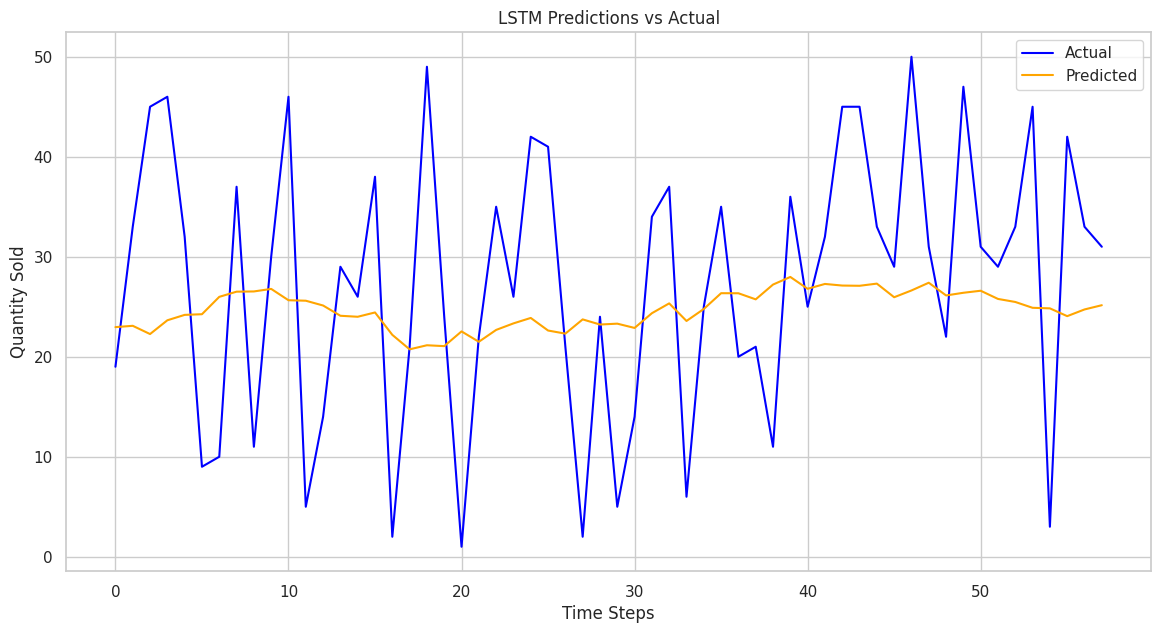

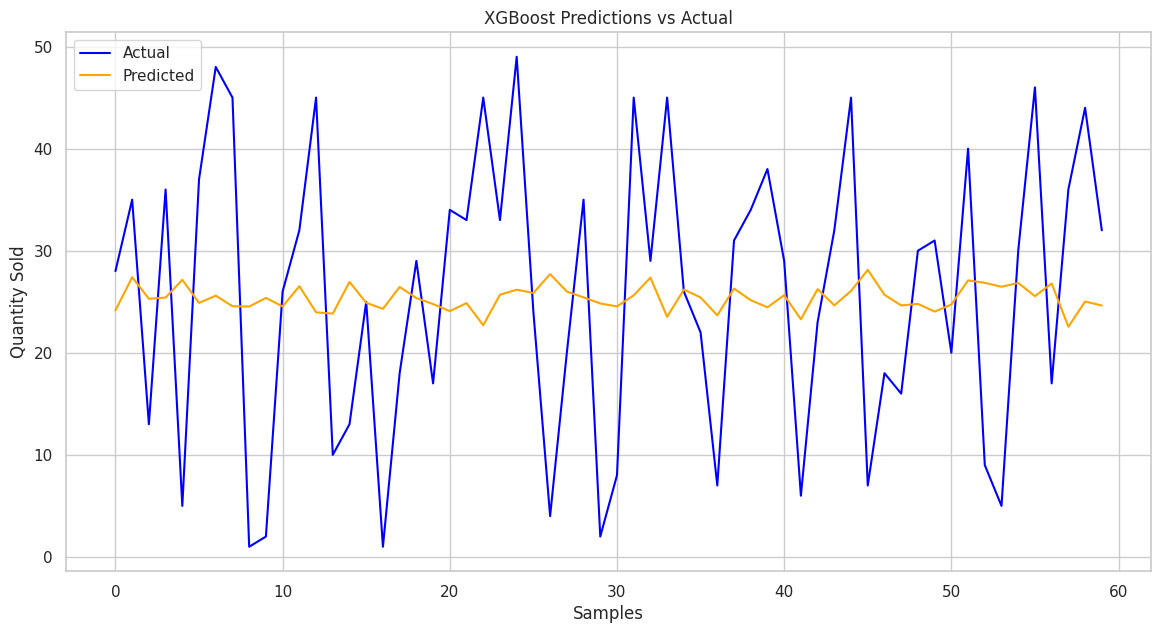

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib
import numpy as np


# Load the dataset
df = pd.read_csv('supply_chain_300_records.csv')

# Feature engineering: convert 'Sales Date' to a numerical format (year, month)
df['Sales Date'] = pd.to_datetime(df['Sales Date'])
df['Year'] = df['Sales Date'].dt.year
df['Month'] = df['Sales Date'].dt.month

# Drop columns not useful for prediction (keep only relevant features)
df = df.drop(['Product Name', 'Sales Date', 'Customer ID', 'Supplier ID', 'Product ID'], axis=1)

# Handle missing values for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Convert categorical data to numerical using one-hot encoding
df = pd.get_dummies(df, columns=['Category', 'Warehouse Location', 'Promotional Campaign', 'Seasonal Indicator'])

# Prepare LSTM data
df_lstm = pd.read_csv('supply_chain_300_records.csv')
df_lstm['Sales Date'] = pd.to_datetime(df_lstm['Sales Date'])
df_lstm['Current Stock Level'] = df_lstm['Current Stock Level'].fillna(df_lstm['Current Stock Level'].mean())
df_lstm['Quantity Sold'] = df_lstm['Quantity Sold'].fillna(df_lstm['Quantity Sold'].mean())
df_lstm = df_lstm[['Sales Date', 'Current Stock Level', 'Quantity Sold']].sort_values('Sales Date')

# Normalize the features for LSTM input
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_lstm[['Current Stock Level', 'Quantity Sold']])

# Prepare the data for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])  # Using 'Current Stock Level' as the input feature
        y.append(data[i, 1])  # Predict 'Quantity Sold'
    return np.array(X), np.array(y)

# Create sequences for LSTM
n_steps = 10
X_lstm, y_lstm = create_sequences(df_scaled, n_steps)

# Reshape X to be (samples, time steps, features)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

# Split the data into training and testing sets for LSTM
train_size = int(len(X_lstm) * 0.8)
X_lstm_train, X_lstm_test = X_lstm[:train_size], X_lstm[train_size:]
y_lstm_train, y_lstm_test = y_lstm[:train_size], y_lstm[train_size:]

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
lstm_model.fit(X_lstm_train, y_lstm_train, epochs=20, batch_size=32, verbose=1)

# Make predictions
y_lstm_pred = lstm_model.predict(X_lstm_test)

# Inverse transform the predicted values
y_lstm_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((y_lstm_pred.shape[0], 1)), y_lstm_pred), axis=1))[:, 1]
y_lstm_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((y_lstm_test.shape[0], 1)), y_lstm_test.reshape(-1, 1)), axis=1))[:, 1]

# Evaluate the LSTM model
lstm_rmse = np.sqrt(np.mean((y_lstm_pred_inv - y_lstm_test_inv) ** 2))
lstm_r2 = r2_score(y_lstm_test_inv, y_lstm_pred_inv)
print(f"LSTM RMSE: {lstm_rmse}, R²: {lstm_r2}")

# Output first 10 predictions
print("LSTM Predicted vs Actual (First 10):")
print(pd.DataFrame({'Predicted': y_lstm_pred_inv[:10], 'Actual': y_lstm_test_inv[:10]}))

# Prepare data for XGBoost
X = df.drop('Quantity Sold', axis=1)
y = df['Quantity Sold']

# Ensure all features are numerical
X = X.select_dtypes(include=[np.number])  # Keep only numerical features

# Split the dataset into training and testing sets for XGBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Make predictions
y_xgb_pred = best_model.predict(X_test)

# Evaluate the XGBoost model
xgb_rmse = mean_squared_error(y_test, y_xgb_pred, squared=False)
xgb_r2 = r2_score(y_test, y_xgb_pred)
print(f"XGBoost RMSE: {xgb_rmse}, R²: {xgb_r2}")

# Output first 10 predictions
print("XGBoost Predicted vs Actual (First 10):")
print(pd.DataFrame({'Predicted': y_xgb_pred[:10], 'Actual': y_test[:10].values}))

# Save models
lstm_model.save('lstm_model.h5')
joblib.dump(best_model, 'xgboost_model.pkl')

# Plotting predictions vs actual for LSTM
plt.figure(figsize=(14, 7))
plt.plot(y_lstm_test_inv, label='Actual', color='blue')
plt.plot(y_lstm_pred_inv, label='Predicted', color='orange')
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()

# Plotting predictions vs actual for XGBoost
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_xgb_pred, label='Predicted', color='orange')
plt.title('XGBoost Predictions vs Actual')
plt.xlabel('Samples')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()


In [ ]:
!pip install networkx matplotlib



In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define the graph: City connections and distances
graph = {
    'City A': [('City B', random.randint(50, 200)), ('City C', random.randint(100, 300)), ('City D', random.randint(200, 400))],
    'City B': [('City A', random.randint(50, 200)), ('City C', random.randint(50, 150)), ('City E', random.randint(100, 250))],
    'City C': [('City A', random.randint(100, 300)), ('City B', random.randint(50, 150)), ('City D', random.randint(100, 200)), ('City F', random.randint(150, 300))],
    'City D': [('City A', random.randint(200, 400)), ('City C', random.randint(100, 200)), ('City F', random.randint(50, 150)), ('City G', random.randint(200, 400))],
    'City E': [('City B', random.randint(100, 250)), ('City F', random.randint(100, 200)), ('City H', random.randint(150, 300))],
    'City F': [('City C', random.randint(150, 300)), ('City D', random.randint(50, 150)), ('City E', random.randint(100, 200)), ('City G', random.randint(100, 250)), ('City I', random.randint(200, 400))],
    'City G': [('City D', random.randint(200, 400)), ('City F', random.randint(100, 250)), ('City I', random.randint(100, 200)), ('City J', random.randint(250, 400))],
    'City H': [('City E', random.randint(150, 300)), ('City I', random.randint(50, 150)), ('City J', random.randint(100, 250))],
    'City I': [('City F', random.randint(200, 400)), ('City G', random.randint(100, 200)), ('City H', random.randint(50, 150)), ('City J', random.randint(50, 150))],
    'City J': [('City G', random.randint(250, 400)), ('City H', random.randint(100, 250)), ('City I', random.randint(50, 150))]
}

# Create the graph in NetworkX
G = nx.Graph()

# Add nodes and edges to the graph
for city, connections in graph.items():
    for neighbor, distance in connections:
        G.add_edge(city, neighbor, weight=distance)

# Visualize the initial graph (as before)
def draw_graph(graph, path=[]):
    pos = nx.spring_layout(graph)  # Position of nodes
    nx.draw(graph, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold')
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

    if path:
        path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
        nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='red', width=2)

    plt.title("City Network Graph with Routes and Distances")
    plt.show()

draw_graph(G)  # Initial graph visualization


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define the graph: City connections and distances
graph = {
    'City A': [('City B', random.randint(50, 200)), ('City C', random.randint(100, 300)), ('City D', random.randint(200, 400))],
    'City B': [('City A', random.randint(50, 200)), ('City C', random.randint(50, 150)), ('City E', random.randint(100, 250))],
    'City C': [('City A', random.randint(100, 300)), ('City B', random.randint(50, 150)), ('City D', random.randint(100, 200)), ('City F', random.randint(150, 300))],
    'City D': [('City A', random.randint(200, 400)), ('City C', random.randint(100, 200)), ('City F', random.randint(50, 150)), ('City G', random.randint(200, 400))],
    'City E': [('City B', random.randint(100, 250)), ('City F', random.randint(100, 200)), ('City H', random.randint(150, 300))],
    'City F': [('City C', random.randint(150, 300)), ('City D', random.randint(50, 150)), ('City E', random.randint(100, 200)), ('City G', random.randint(100, 250)), ('City I', random.randint(200, 400))],
    'City G': [('City D', random.randint(200, 400)), ('City F', random.randint(100, 250)), ('City I', random.randint(100, 200)), ('City J', random.randint(250, 400))],
    'City H': [('City E', random.randint(150, 300)), ('City I', random.randint(50, 150)), ('City J', random.randint(100, 250))],
    'City I': [('City F', random.randint(200, 400)), ('City G', random.randint(100, 200)), ('City H', random.randint(50, 150)), ('City J', random.randint(50, 150))],
    'City J': [('City G', random.randint(250, 400)), ('City H', random.randint(100, 250)), ('City I', random.randint(50, 150))]
}

# Create the graph in NetworkX
G = nx.Graph()

# Add nodes and edges to the graph
for city, connections in graph.items():
    for neighbor, distance in connections:
        G.add_edge(city, neighbor, weight=distance)

# Visualize the initial graph (as before)
def draw_graph(graph, path=[]):
    pos = nx.spring_layout(graph)  # Position of nodes
    nx.draw(graph, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold')
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

    if path:
        path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
        nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='red', width=2)

    plt.title("City Network Graph with Routes and Distances")
    plt.show()

draw_graph(G)  # Initial graph visualization